<a href="https://colab.research.google.com/github/diman199888/quantitative-finance/blob/main/crypto-arbitrage-model/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import crypto_arb_utils as cc

import importlib
importlib.reload(cc)

from sqlalchemy import create_engine
import sqlite3
import psycopg2

import pandas as pd
import numpy as np
import polars as pl

import time
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import logging

import statsmodels.api as sm

from tqdm import tqdm


pd.set_option('display.max_columns',  None)
#pd.set_option('display.max_rows', 250)
#pd.set_option('display.float_format', '{:.5f}'.format)
from IPython.display import display


import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, zero_one_loss, make_scorer, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
!pip install optuna
import optuna
!pip install xgboost
from xgboost import XGBClassifier

!pip install cuml-cu11 --extra-index-url https://pypi.ngc.nvidia.com
from cuml.svm import SVC as cuSVC

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Gett

ERROR:ptxcompiler.patch:Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba


ModuleNotFoundError: No module named 'cuda.bindings.runtime'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import shutil
import os

# Define the source path (where your uploaded database is)
source_path = '/content/crypto.db' # Replace with the actual path if different

# Define the destination path in your Google Drive
# Replace 'My Drive/Databases' with the desired folder path in your Drive
destination_folder = '/content/drive/My Drive/Databases'
destination_path = os.path.join(destination_folder, 'crypto.db')

# Create the destination folder in Drive if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the file
try:
    shutil.copyfile(source_path, destination_path)
    print(f"Database saved to {destination_path}")
except FileNotFoundError:
    print(f"Error: Source file not found at {source_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Database saved to /content/drive/My Drive/Databases/crypto.db


In [ ]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

In [ ]:
database_path_in_drive = '/content/drive/My Drive/Databases/crypto.db'
engine = create_engine(f"sqlite:///{database_path_in_drive}")
df = cc.download_data(engine)
df

exchange,ts,side,level1_price,level1_size,level2_price,level2_size,level3_price,level3_size
str,i64,str,f64,f64,f64,f64,f64,f64
"""Bybit""",1744811324776,"""bid""",74.06,68.30026,74.05,93.52903,74.04,156.80797
"""Bybit""",1744811324776,"""ask""",74.08,16.93638,74.09,48.66282,74.1,47.20968
"""Bybit""",1744811324896,"""bid""",74.06,68.30026,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811324976,"""bid""",74.06,71.67544,74.05,100.28442,74.04,156.80797
"""Bybit""",1744811325196,"""bid""",74.07,8.1,74.06,71.67544,74.05,100.28442
…,…,…,…,…,…,…,…,…
"""Bybit""",1746643832136,"""ask""",87.94,0.17196,87.95,85.63987,87.96,94.85292
"""HTX""",1746643832109,"""ask""",87.93,21.8137,87.94,3.24,87.95,20.14
"""Bybit""",1746643832176,"""ask""",87.94,0.17196,87.95,89.67909,87.96,94.85292


In [ ]:
exchange1 = "HTX"
exchange2 = "Bybit"

In [ ]:
df_exchange1 = cc.get_orderbook_snapshot(df, exchange1)
df_exchange2 = cc.get_orderbook_snapshot(df, exchange2)

In [ ]:
df_merged = cc.merge_data(df_exchange1, exchange1, df_exchange2, exchange2)
df_merged

ts,HTX_level1_price_bid,HTX_level1_size_bid,HTX_level2_price_bid,HTX_level2_size_bid,HTX_level3_price_bid,HTX_level3_size_bid,HTX_level1_price_ask,HTX_level1_size_ask,HTX_level2_price_ask,HTX_level2_size_ask,HTX_level3_price_ask,HTX_level3_size_ask,HTX_delta_ts,Bybit_level1_price_bid,Bybit_level1_size_bid,Bybit_level2_price_bid,Bybit_level2_size_bid,Bybit_level3_price_bid,Bybit_level3_size_bid,Bybit_level1_price_ask,Bybit_level1_size_ask,Bybit_level2_price_ask,Bybit_level2_size_ask,Bybit_level3_price_ask,Bybit_level3_size_ask,Bybit_delta_ts,timedelta
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1744811325304,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,28,74.07,13.48915,74.06,93.78829,74.05,145.46272,74.08,0.37586,74.09,13.76403,74.1,32.88344,28,28
1744811325336,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,32,74.07,20.23905,74.06,85.77832,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-32
1744811325356,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,52,74.07,20.23905,74.06,121.54773,74.05,145.46272,74.08,0.37586,74.09,8.62298,74.1,32.88344,20,-52
1744811325416,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,112,74.07,23.614,74.06,121.54773,74.05,142.08686,74.08,0.37586,74.09,8.62298,74.1,32.88344,60,-112
1744811325436,74.07,4.86,74.06,6.6699,74.05,9.72,74.08,4.86,74.09,4.86,74.12,4.86,132,74.07,34.86054,74.06,121.54773,74.05,152.56376,74.08,0.37586,74.09,8.62298,74.1,41.33886,20,-132
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1746643832117,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,8,87.93,16.76849,87.92,37.4852,87.91,37.59036,87.94,0.17196,87.95,85.63987,87.96,90.64008,21,-8
1746643832136,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,27,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,85.63987,87.96,94.85292,19,-27
1746643832176,87.91,6.48,87.9,23.85,87.89,21.24,87.93,21.8137,87.94,3.24,87.95,20.14,67,87.93,16.76849,87.92,37.4852,87.91,42.41956,87.94,0.17196,87.95,89.67909,87.96,94.85292,40,-67


In [ ]:
df_strategy = cc.strategy(df_merged, exchange1, exchange2)

In [ ]:
df_n = cc.duration_calculation(df_strategy)

In [ ]:
df_n.write_parquet('/content/drive/MyDrive/df_n.parquet')


In [ ]:
exchange1 = "HTX"
exchange2 = "Bybit"
df_n = pl.read_parquet('/content/drive/MyDrive/df_n.parquet')

In [ ]:
def feature_selection_1(df, exchange1, exchange2, roll: str = '10s'):

    base = ['ts', "Bybit_delta_ts", 'HTX_delta_ts', 'timedelta', "arb_opportunity", 'length',
        'till_arbitrage', 'since_last_arbitrage', 'arbitrage_start', 'active_arbitrage', 'arbitrage_id']

    columns_to_roll = df.drop(base).columns

    df = df.with_columns(
    pl.col("ts").cast(pl.Datetime(time_unit='ms')))

    df = df.with_columns([
        pl.col(col).rolling_mean_by(
            "ts",
            window_size=roll,
            closed="left"
        ).alias(f"{col}_rolling_avg_{roll}") for col in columns_to_roll
    ])

    df = df.with_columns([
        pl.col(col).rolling_min_by(
        "ts",
        window_size=roll,
        closed="left"
        ).alias(f"{col}_rolling_min_{roll}") for col in columns_to_roll
    ])

    df = df.with_columns([
        pl.col(col).rolling_max_by(
        "ts",
        window_size=roll,
        closed="left"
        ).alias(f"{col}_rolling_max_{roll}") for col in columns_to_roll
    ])

    df_train = df.select([
        pl.col(
            base
            ),

        *[(pl.col(col) / pl.col(f"{col}_rolling_avg_{roll}") - 1)
        .alias(f"{col}_vs_avg") for col in columns_to_roll],

        *[(pl.col(col) / pl.col(f"{col}_rolling_min_{roll}") - 1)
        .alias(f"{col}_vs_min") for col in columns_to_roll],

        *[(pl.col(col) / pl.col(f"{col}_rolling_max_{roll}") - 1)
        .alias(f"{col}_vs_max") for col in columns_to_roll],


        # Spreads
        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_ask_spread"),
        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_ask_spread"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_spread"),

        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_spread"),
        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_ask_spread"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_ask_spread"),

        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_spread"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_spread"),


        # Imbalance
        ((pl.col(f"{exchange1}_level1_size_bid") - pl.col(f"{exchange1}_level1_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level1_size_ask"))
        ).alias(f"{exchange1}_level1_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") - pl.col(f"{exchange2}_level1_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level1_size_ask"))
        ).alias(f"{exchange2}_level1_imbalance"),

        ((pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") -
          pl.col(f"{exchange1}_level1_size_ask") - pl.col(f"{exchange1}_level2_size_ask") - pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") +
          pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_aggregated_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") -
          pl.col(f"{exchange2}_level1_size_ask") - pl.col(f"{exchange2}_level2_size_ask") - pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") +
          pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_aggregated_imbalance"),


        # Top-level quote weight
        (pl.col(f"{exchange1}_level1_size_bid") /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_weight"),

        (pl.col(f"{exchange1}_level1_size_ask") /
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_weight"),

        (pl.col(f"{exchange2}_level1_size_bid") /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_weight"),

        (pl.col(f"{exchange2}_level1_size_ask") /
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_weight")])

    df_train = df_train.with_columns(pl.col("ts").cast(pl.Int64))

    return df_train

df_train = feature_selection_1(df_n, exchange1, exchange2, roll = '1m')

In [ ]:
df_train.write_parquet('/content/drive/MyDrive/df_train.parquet')
df_train

ts,Bybit_delta_ts,HTX_delta_ts,timedelta,arb_opportunity,length,till_arbitrage,since_last_arbitrage,arbitrage_start,active_arbitrage,arbitrage_id,HTX_level1_price_bid_vs_avg,HTX_level1_size_bid_vs_avg,HTX_level2_price_bid_vs_avg,HTX_level2_size_bid_vs_avg,HTX_level3_price_bid_vs_avg,HTX_level3_size_bid_vs_avg,HTX_level1_price_ask_vs_avg,HTX_level1_size_ask_vs_avg,HTX_level2_price_ask_vs_avg,HTX_level2_size_ask_vs_avg,HTX_level3_price_ask_vs_avg,HTX_level3_size_ask_vs_avg,Bybit_level1_price_bid_vs_avg,Bybit_level1_size_bid_vs_avg,Bybit_level2_price_bid_vs_avg,Bybit_level2_size_bid_vs_avg,Bybit_level3_price_bid_vs_avg,Bybit_level3_size_bid_vs_avg,Bybit_level1_price_ask_vs_avg,Bybit_level1_size_ask_vs_avg,Bybit_level2_price_ask_vs_avg,Bybit_level2_size_ask_vs_avg,Bybit_level3_price_ask_vs_avg,Bybit_level3_size_ask_vs_avg,HTX_level1_price_bid_vs_min,HTX_level1_size_bid_vs_min,…,HTX_level2_size_ask_vs_max,HTX_level3_price_ask_vs_max,HTX_level3_size_ask_vs_max,Bybit_level1_price_bid_vs_max,Bybit_level1_size_bid_vs_max,Bybit_level2_price_bid_vs_max,Bybit_level2_size_bid_vs_max,Bybit_level3_price_bid_vs_max,Bybit_level3_size_bid_vs_max,Bybit_level1_price_ask_vs_max,Bybit_level1_size_ask_vs_max,Bybit_level2_price_ask_vs_max,Bybit_level2_size_ask_vs_max,Bybit_level3_price_ask_vs_max,Bybit_level3_size_ask_vs_max,HTX_level1_bid_ask_spread,HTX_level2_bid_ask_spread,HTX_level3_bid_ask_spread,HTX_level1_ask_spread,HTX_level2_ask_spread,HTX_level1_bid_spread,HTX_level2_bid_spread,Bybit_level1_bid_ask_spread,Bybit_level2_bid_ask_spread,Bybit_level3_bid_ask_spread,Bybit_level1_bid_spread,Bybit_level2_bid_spread,Bybit_level1_ask_spread,Bybit_level2_ask_spread,HTX_level1_imbalance,Bybit_level1_imbalance,HTX_aggregated_imbalance,Bybit_aggregated_imbalance,HTX_bid_weight,HTX_ask_weight,Bybit_bid_weight,Bybit_ask_weight
i64,i64,i64,i64,f64,i64,i64,i64,bool,bool,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64
1744811325304,28,28,28,0.0,null,null,null,false,false,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.945783,0.186155,0.686264,0.228707,0.333333,0.053372,0.007993
1744811325336,60,32,-32,0.0,null,null,null,false,false,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500395,0.0,-0.085405,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.500395,0.0,-0.085405,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.963535,0.186155,0.714467,0.228707,0.333333,0.08048,0.008974
1744811325356,20,52,-52,0.0,null,null,null,false,false,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200126,0.0,0.35379,0.0,0.0,0.0,0.0,0.0,-0.229644,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.29598,0.0,0.0,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.963535,0.186155,0.745498,0.228707,0.333333,0.070458,0.008974
1744811325416,60,112,-112,0.0,null,null,null,false,false,null,0.0,0.0,0.0,-1.1102e-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.312685,0.0,0.210979,0.0,-0.023208,0.0,0.0,0.0,-0.165787,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.166754,0.0,0.0,0.0,-0.023208,0.0,0.0,0.0,-0.373513,0.0,0.0,0.01,0.03,0.07,0.01,0.03,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.0,0.968665,0.186155,0.745498,0.228707,0.333333,0.082208,0.008974
1744811325436,20,132,-132,0.0,null,null,null,false,false,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.797369,0.0,0.150306,0.0,0.054938,0.0,0.0,0.0,-0.129716,0.0,0.257133,0.0,0.0,…,0.0,0.0,0.0,0.0,0.476266,0.0,0.0,0.0,0.048817,0.0,0.0,0.0,-0.373513,0.0,0.2571

In [ ]:
arbitrage_model = cc.final_manipulations(df_train, include_first_observation = False, n_lags = 1)
arbitrage_model

ts,Bybit_delta_ts,HTX_delta_ts,timedelta,arb_opportunity,length,till_arbitrage,since_last_arbitrage,arbitrage_id,HTX_level1_price_bid_vs_avg,HTX_level1_size_bid_vs_avg,HTX_level2_price_bid_vs_avg,HTX_level2_size_bid_vs_avg,HTX_level3_price_bid_vs_avg,HTX_level3_size_bid_vs_avg,HTX_level1_price_ask_vs_avg,HTX_level1_size_ask_vs_avg,HTX_level2_price_ask_vs_avg,HTX_level2_size_ask_vs_avg,HTX_level3_price_ask_vs_avg,HTX_level3_size_ask_vs_avg,Bybit_level1_price_bid_vs_avg,Bybit_level1_size_bid_vs_avg,Bybit_level2_price_bid_vs_avg,Bybit_level2_size_bid_vs_avg,Bybit_level3_price_bid_vs_avg,Bybit_level3_size_bid_vs_avg,Bybit_level1_price_ask_vs_avg,Bybit_level1_size_ask_vs_avg,Bybit_level2_price_ask_vs_avg,Bybit_level2_size_ask_vs_avg,Bybit_level3_price_ask_vs_avg,Bybit_level3_size_ask_vs_avg,HTX_level1_price_bid_vs_min,HTX_level1_size_bid_vs_min,HTX_level2_price_bid_vs_min,HTX_level2_size_bid_vs_min,…,HTX_level3_price_ask_vs_max_lag_1,HTX_level3_size_ask_vs_max_lag_1,Bybit_level1_price_bid_vs_max_lag_1,Bybit_level1_size_bid_vs_max_lag_1,Bybit_level2_price_bid_vs_max_lag_1,Bybit_level2_size_bid_vs_max_lag_1,Bybit_level3_price_bid_vs_max_lag_1,Bybit_level3_size_bid_vs_max_lag_1,Bybit_level1_price_ask_vs_max_lag_1,Bybit_level1_size_ask_vs_max_lag_1,Bybit_level2_price_ask_vs_max_lag_1,Bybit_level2_size_ask_vs_max_lag_1,Bybit_level3_price_ask_vs_max_lag_1,Bybit_level3_size_ask_vs_max_lag_1,HTX_level1_bid_ask_spread_lag_1,HTX_level2_bid_ask_spread_lag_1,HTX_level3_bid_ask_spread_lag_1,HTX_level1_ask_spread_lag_1,HTX_level2_ask_spread_lag_1,HTX_level1_bid_spread_lag_1,HTX_level2_bid_spread_lag_1,Bybit_level1_bid_ask_spread_lag_1,Bybit_level2_bid_ask_spread_lag_1,Bybit_level3_bid_ask_spread_lag_1,Bybit_level1_bid_spread_lag_1,Bybit_level2_bid_spread_lag_1,Bybit_level1_ask_spread_lag_1,Bybit_level2_ask_spread_lag_1,HTX_level1_imbalance_lag_1,Bybit_level1_imbalance_lag_1,HTX_aggregated_imbalance_lag_1,Bybit_aggregated_imbalance_lag_1,HTX_bid_weight_lag_1,HTX_ask_weight_lag_1,Bybit_bid_weight_lag_1,Bybit_ask_weight_lag_1,dummy
i64,i64,i64,i64,f64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,i8
1744811680996,20,177,-177,0.040689,280,1060,20,2,-0.000139,1.335391,-0.000107,0.297335,-0.000214,1.818753,-0.000275,1.12043,-0.000173,-0.479028,-0.000193,-0.69251,0.000155,-0.007274,0.000155,0.20354,0.000155,-0.376494,0.000146,0.013009,0.000146,0.18619,0.000146,0.127498,0.00095,85.262632,0.001087,50.157895,…,-0.001083,-0.933624,-0.000813,-0.937004,-0.000813,-0.709903,-0.000813,-0.80453,-0.000813,-0.746638,-0.000813,-0.432653,-0.000812,-0.29323,0.01,0.04,0.07,0.02,0.01,0.01,0.02,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.243134,-0.647455,0.242003,-0.510353,0.273002,0.734716,0.064707,0.098029,0
1744811801796,20,24,-24,0.040689,60,340,120500,3,0.000458,2.111779,0.000502,0.341535,0.000526,0.110327,0.000195,0.781955,0.000311,-0.659057,0.000256,-0.990745,0.000674,-0.603479,0.000674,-0.470341,0.000675,-0.615662,0.000651,0.66036,0.000651,0.517156,0.000651,0.271709,0.001086,3.875533,0.001087,2.6422,…,-0.000136,-0.997221,0.000136,-0.988286,0.000136,-0.88339,0.000136,-0.753041,0.000136,-0.054856,0.000136,-0.42551,0.000136,-0.413824,0.01,0.04,0.06,0.02,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.031648,-0.964886,0.43514,-0.553928,0.303662,0.821943,0.01857,0.298295,0
1744811801976,20,149,-149,0.040689,520,520,100,4,0.000456,2.081402,0.000499,-0.205048,0.000523,0.110375,0.000194,0.774075,0.00031,-0.658282,0.000255,-0.990668,0.000671,-0.766789,0.000671,-0.268199,0.000671,-0.489437,0.000647,0.65877,0.000647,0.417922,0.000647,0.051474,0.001086,3.875533,0.001087,1.16,…,-0.000136,-0.997221,0.0,-0.944762,0.0,-0.829244,0.0,-0.806587,0.0,-0.585849,0.0,-0.365379,0.0,-0.514956,0.01,0.04,0.06,0.02,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.

In [ ]:
def matrix(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_pred, y_test, labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.show()
  return cm

In [ ]:
arbitrage_model = arbitrage_model.to_pandas()

              precision    recall  f1-score   support

           0       0.75      0.60      0.67      8914
           1       0.48      0.65      0.55      5006

    accuracy                           0.62     13920
   macro avg       0.61      0.62      0.61     13920
weighted avg       0.65      0.62      0.63     13920



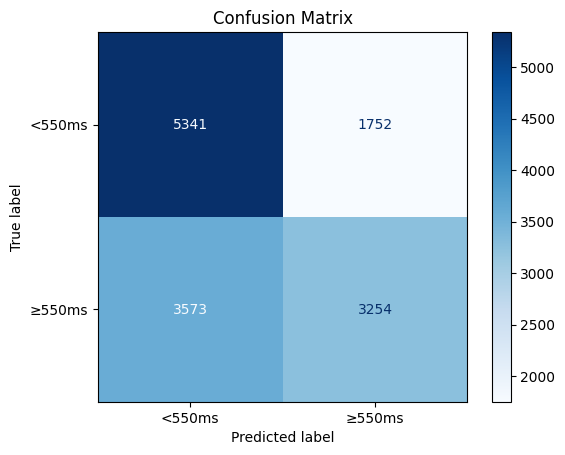

In [ ]:
X = arbitrage_model.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id' ])
y = arbitrage_model["dummy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(**{'C': 1, 'fit_intercept': True, 'intercept_scaling': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}, class_weight='balanced', max_iter=10000).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred  = clf.predict(X_test_scaled)
cm1 = matrix(y_test, y_pred)


In [ ]:
y_test[y_test == 0].shape[0] / y_test.shape[0]

0.6403735632183908

In [ ]:
accuracy_score(y_test, y_pred)

0.6174568965517241

In [ ]:
accuracy_score(y_test, y_pred)

0.6880028735632184

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      8914
           1       0.56      0.45      0.50      5006

    accuracy                           0.68     13920
   macro avg       0.64      0.63      0.63     13920
weighted avg       0.66      0.68      0.67     13920



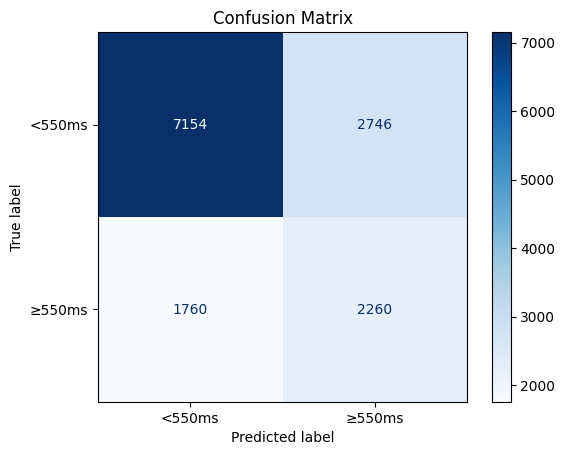

In [ ]:
best_params = {'objective': 'binary:logistic',
 'eval_metric': 'error',
 'n_estimators': 827,
 'learning_rate': 0.5612403948506814,
 'max_depth': 9,
 'max_leaves': 6,
 'min_child_weight': 1,
 'subsample': 0.7377291105293949,
 'colsample_bytree': 0.854772161567795,
 'gamma': 1.3236554925385269,
 'reg_alpha': 0.00011289754307432173,
 'reg_lambda': 0.8602760073845163}

model = XGBClassifier(
    n_jobs=-1,
    **best_params
)


model.fit(
    X_train,
    y_train,
)


y_pred_xgb  = model.predict(X_test)
XGB_cm1 = matrix(y_test, y_pred_xgb)

In [ ]:
X = arbitrage_model.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id'])
y = arbitrage_model["dummy"]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      8914
           1       0.56      0.45      0.50      5006

    accuracy                           0.68     13920
   macro avg       0.64      0.63      0.63     13920
weighted avg       0.66      0.68      0.67     13920



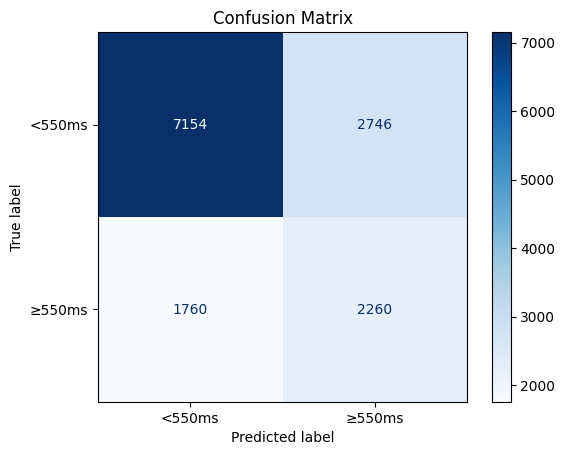

In [ ]:
svm = SVC().fit(X_train_scaled, y_train)
y_pred_svm  = svm.predict(X_test_scaled)
cm_svm = matrix(y_test, y_pred_svm)

In [ ]:
%%time
y_train_pred_svm  = svm.predict(X_train_scaled)
y_train_pred_svm

CPU times: user 6min 39s, sys: 388 ms, total: 6min 40s
Wall time: 6min 39s


array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
from cuml.svm import SVC as cuSVC

# Train the cuML SVC model on the GPU
cu_svm = cuSVC().fit(X_train_scaled, y_train)

# Make predictions using the cuML SVC model
y_pred_cu_svm = cu_svm.predict(X_test_scaled)

# Evaluate the model (using your existing matrix function or scikit-learn metrics)
cm_cu_svm = matrix(y_test, y_pred_cu_svm)

In [ ]:
y_train_pred_xgb  = model.predict(X_train)
y_train_pred_log  = clf.predict(X_train_scaled)

In [ ]:
X_avg = np.vstack([y_train_pred_svm, y_train_pred_log, y_train_pred_xgb])
X_test_avg = np.vstack([y_pred_svm, y_pred, y_pred_xgb])

In [ ]:
beta = np.linalg.pinv(X_avg.T) @ y_train
beta

array([0.04434056, 0.17152768, 0.66416052])

In [ ]:
y_pred_avg = X_test_avg.T @ beta
y_pred_avg_binary = (y_pred_avg >= 0.5).astype(int)
y_pred_avg_binary

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
accuracy_score(y_test, y_pred_avg_binary)

0.6762931034482759

In [ ]:
# Get feature names
feature_names = X_train.columns

# Get the coefficients from the fitted model
coefficients = clf.coef_[0]

# Create a list of (feature_name, coefficient) pairs
feature_importance = list(zip(feature_names, coefficients))

# Sort the features by the absolute value of their coefficients
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=False)

# Print the sorted list of feature importance
print("Most important features for Logistic Regression:")
for feature, coef in feature_importance_sorted:
    print(f"{feature}: {coef}")

Most important features for Logistic Regression:
Bybit_aggregated_imbalance_lag_2: -2.1832314986356995e-05
Bybit_level1_bid_spread_lag_8: 0.00010065598632550855
HTX_level2_ask_price_change_lag_3: 0.00014161195648295418
Bybit_level1_2tick_price_ask_vol_lag_1: -0.0001569499995014503
HTX_bid_weight_lag_6: -0.00021373112403155883
HTX_level2_ask_spread_lag_7: -0.0003998685333193371
HTX_level3_ask_price_change_2tick_lag_2: 0.00041858341205835937
Bybit_ask_weight_lag_10: 0.0004260063352929543
Bybit_level1_imbalance_lag_8: 0.0004334408281504101
HTX_level3_2tick_size_ask_vol: 0.0004518093749862872
Bybit_level2_bid_ask_spread_change_lag_2: 0.000551695251416558
HTX_level2_bid_ask_spread_change_lag_4: 0.0005937852239573463
Bybit_level3_ask_size_change_lag_7: 0.0006137694534263293
Bybit_level3_ask_size_change: -0.0006786357841599398
Bybit_level1_bid_size_change_lag_6: 0.0006916932696319718
HTX_level3_ask_price_change_lag_2: -0.0007813283056019193
HTX_level3_2tick_price_ask_vol_lag_3: 0.000867299389

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test_scaled, y_test,
    scoring='f1',    # or 'accuracy', 'f1', etc.
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_imp = pd.Series(result.importances_mean, index=X_test.columns)
perm_imp = perm_imp.sort_values(ascending=False)

print("Top 10 by permutation importance:")
print(perm_imp.head(10))

Top 10 by permutation importance:
HTX_level1_price_ask_vs_avg_lag_1      0.052576
HTX_level1_price_ask_vs_avg            0.050698
Bybit_level1_price_bid_vs_avg_lag_1    0.024646
Bybit_level2_price_bid_vs_avg_lag_1    0.024490
Bybit_level3_price_bid_vs_avg_lag_1    0.024291
Bybit_level1_imbalance                 0.023689
arb_opportunity                        0.022011
Bybit_bid_weight                       0.016085
HTX_level1_price_ask_vs_max_lag_1      0.013077
HTX_level1_price_ask_vs_max            0.013072
dtype: float64


In [ ]:

Cs = [0.01, 0.1, 1, 10, 100]

param_grid = [
    # solvers that only support l2 or no penalty
    {
        'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'penalty': ['l2', None],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    },

    # liblinear only supports l1 or l2
    {
        'solver': ['liblinear'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'penalty': ['l1','l2'],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    },

    # saga supports all four, but elasticnet *requires* l1_ratio
    {
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 5, 10, 20],
        'solver': ['saga'],
        'penalty': ['l1','l2','elasticnet', None],
        'l1_ratio': [0.0, 0.5, 1.0],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': Cs
    }
]

# NOTE: saga supports all three penalties
base = LogisticRegression(
    class_weight='balanced',
    max_iter=100000,
    random_state = 42
)

grid = GridSearchCV(
    base,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    refit=True
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)

# evaluate on test set
y_pred  = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def objective_xgb(trial):
    # Define hyperparameters to tune
    params = {
        "objective": trial.suggest_categorical("objective", ["binary:hinge", "binary:logistic"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["error", "auc"]),
        "random_state": 42,
        "n_jobs": -1,
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'max_leaves': trial.suggest_int("max_leaves", 0, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
    }

    # Create the XGBoost model with suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model (using AUC is often good for imbalance)
    # If using binary:logistic, use predict_proba
    y_pred = model.predict(X_test)
    metric_value = f1_score(y_test, y_pred) # Or another suitable metric

    return metric_value

# Create and run the Optuna study
optuna.logging.set_verbosity(optuna.logging.INFO)
study_xgb = optuna.create_study(direction="maximize") # Maximize AUC or accuracy
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True) # Adjust n_trials as needed

print("Best trial:")
trial_xgb = study_xgb.best_trial

print(f"  Value: {trial_xgb.value}")
print("  Params: ")
for key, value in trial_xgb.params.items():
    print(f"    {key}: {value}")

[I 2025-05-14 10:45:05,071] A new study created in memory with name: no-name-8767573f-7432-4520-ab28-c5eb8457ff66


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-14 10:45:12,032] Trial 0 finished with value: 0.4371155607904724 and parameters: {'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 928, 'learning_rate': 0.04264152717232335, 'max_depth': 7, 'max_leaves': 4, 'min_child_weight': 2, 'subsample': 0.9653757820280305, 'colsample_bytree': 0.8339889938100661, 'gamma': 1.8969071470173238, 'reg_alpha': 0.04953153564702197, 'reg_lambda': 0.05139491301233118}. Best is trial 0 with value: 0.4371155607904724.
[I 2025-05-14 10:45:14,888] Trial 1 finished with value: 0.4010423810176931 and parameters: {'objective': 'binary:logistic', 'eval_metric': 'error', 'n_estimators': 332, 'learning_rate': 0.043665416194974965, 'max_depth': 9, 'max_leaves': 3, 'min_child_weight': 5, 'subsample': 0.6731223533235979, 'colsample_bytree': 0.9561315651238458, 'gamma': 4.261996544416017, 'reg_alpha': 0.00018610119017076635, 'reg_lambda': 0.0003641148759648704}. Best is trial 0 with value: 0.4371155607904724.
[I 2025-05-14 10:45:21,131]

In [ ]:
accuracy_score(y_test, y_pred)

0.6762931034482759

In [ ]:
arbitrage_model_2['hour'] = pd.to_datetime(arbitrage_model_2['ts'], unit = 'ms').dt.hour
hour_data = arbitrage_model_2[['hour']]

encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the hour data
hour_encoded = encoder.fit_transform(hour_data)

# Create a DataFrame from the encoded data
# The feature_names_in_ attribute gives the names of the input features
# The get_feature_names_out() method generates output feature names
encoded_hour_df = pd.DataFrame(hour_encoded, columns=encoder.get_feature_names_out(['hour']))

# Ensure the indices align before concatenating
encoded_hour_df.index = arbitrage_model_2.index

# 4. Concatenate with the original DataFrame
arbitrage_model_2_with_hour_dummies = pd.concat([arbitrage_model_2, encoded_hour_df], axis=1)

# Drop the original 'hour' column if you no longer need it
arbitrage_model_2_with_hour_dummies = arbitrage_model_2_with_hour_dummies.drop('hour', axis=1)

In [ ]:
arbitrage_model_2_with_hour_dummies

,ts,Bybit_delta_ts,HTX_delta_ts,timedelta,arbitrage_id,arb_opportunity,length,till_arbitrage,since_last_arbitrage,HTX_level1_bid_ask_spread,HTX_level2_bid_ask_spread,HTX_level3_bid_ask_spread,HTX_level1_ask_spread,HTX_level2_ask_spread,HTX_level1_bid_spread,HTX_level2_bid_spread,Bybit_level1_bid_ask_spread,Bybit_level2_bid_ask_spread,Bybit_level3_bid_ask_spread,Bybit_level1_bid_spread,Bybit_level2_bid_spread,Bybit_level1_ask_spread,Bybit_level2_ask_spread,HTX_level1_imbalance,Bybit_level1_imbalance,HTX_aggregated_imbalance,Bybit_aggregated_imbalance,HTX_bid_rel_vwap,HTX_ask_rel_vwap,Bybit_bid_rel_vwap,Bybit_ask_rel_vwap,HTX_bid_weight,HTX_ask_weight,Bybit_bid_weight,Bybit_ask_weight,HTX_bid_price_change,HTX_ask_price_change,Bybit_bid_price_change,Bybit_ask_price_change,HTX_2tick_price_bid_vol,Bybit_2tick_price_bid_vol,HTX_2tick_price_ask_vol,Bybit_2tick_price_ask_vol,HTX_bid_size_change,HTX_ask_size_change,Bybit_bid_size_change,Bybit_ask_size_change,HTX_2tick_size_bid_vol,Bybit_2tick_size_bid_vol,HTX_2tick_size_ask_vol,Bybit_2tick_size_ask_vol,HTX_level1_bid_ask_spread_change,HTX_level2_bid_ask_spread_change,Bybit_level1_bid_ask_spread_change,Bybit_level2_bid_ask_spread_change,dummy,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1744811680996,20,177,-177,2.0,0.040689,280.0,1060.0,20.0,0.01,0.04,0.07,0.02,0.01,0.01,0.02,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.243134,-0.238849,0.242003,-0.330043,1.000252,0.999910,1.000163,0.999816,0.273002,0.734716,0.151277,0.124023,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.00000,1.871119,0.000000,0.000000,0.575328,0.00000,0.414623,0.0,0.00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1744811801796,20,24,-24,3.0,0.040689,60.0,340.0,120500.0,0.01,0.04,0.06,0.02,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.031648,-0.507137,0.435140,-0.487808,1.000158,0.999951,1.000168,0.999820,0.303662,0.821943,0.140553,0.147963,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.01,0.0,0.00000,7.018373,-0.561811,0.000000,0.494678,0.00000,0.905434,0.0,0.00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1744811801976,20,149,-149,4.0,0.040689,520.0,520.0,100.0,0.01,0.04,0.06,0.02,0.01,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,-0.031648,-0.677393,0.395067,-0.350795,1.000160,0.999951,1.000182,0.999827,0.334546,0.821943,0.066230,0.165503,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.00000,0.000000,0.000000,0.000000,0.802574,0.00000,0.150844,0.0,0.00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1744811803665,9,9,9,6.0,0.040689,1045.0,2220.0,60.0,0.01,0.06,0.11,0.04,0.01,0.01,0.04,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.427733,-0.612216,0.531097,-0.457619,1.000131,0.999629,1.000195,0.999811,0.311484,0.407669,0.061977,0.095880,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,-0.35594,0.000000,0.000000,0.436798,0.839207,0.35594,0.000000,0.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1744811877676,20,37,-37,7.0,0.040617,33.0,4060.0,72946.0,0.01,0.04,0.07,0.02,0.02,0.01,0.01,0.01,0.03,0.05,0.01,0.01,0.01,0.01,0.962553,-0.132751,0.890650,-0.218320,1.000222,0.999730,1.000181,0.999793,0.126215,0.041639,0.121839,0.102104,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.01,0.0,0.00000,0.426666,-0.428555,0.000000,0.368118,0.00000,49.506708,0.0,0.00,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69591,1746643689796,20,253,-253,94387.0,0.034184,11

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      8959
           1       0.45      0.60      0.52      4961

    accuracy                           0.60     13920
   macro avg       0.59      0.60      0.59     13920
weighted avg       0.63      0.60      0.61     13920



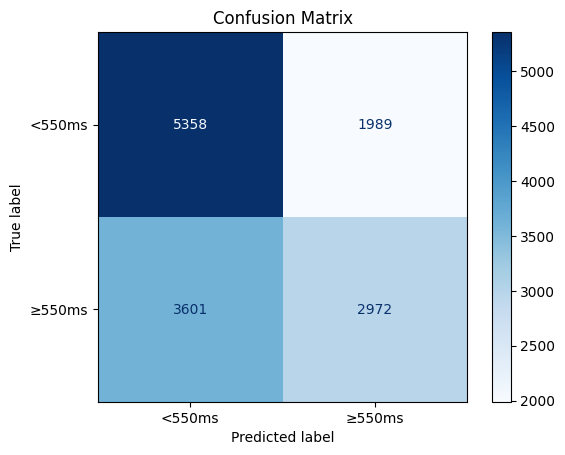

In [ ]:
X = arbitrage_model_2_with_hour_dummies.drop(columns = ['ts', 'length', 'dummy', 'arbitrage_id' ])
y = arbitrage_model_2_with_hour_dummies["dummy"]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = LogisticRegression(**{'C': 1, 'fit_intercept': True, 'intercept_scaling': 1, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.001}, class_weight='balanced', max_iter=10000).fit(X_train_scaled, y_train)

# evaluate on test set
y_pred  = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_pred, y_test, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<550ms","≥550ms"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

t2 = X_train.index.sort_values()

In [ ]:
def objective_xgb(trial):
    # Define hyperparameters to tune
    params = {
        "objective": trial.suggest_categorical("objective", ["binary:hinge", "binary:logistic"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["error", "auc"]),
        "random_state": 42,
        "n_jobs": -1,
        'device': 'cuda',
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        'max_leaves': trial.suggest_int("max_leaves", 0, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
    }

    # Create the XGBoost model with suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model (using AUC is often good for imbalance)
    # If using binary:logistic, use predict_proba
    y_pred = model.predict(X_test)
    metric_value = f1_score(y_test, y_pred) # Or another suitable metric

    return metric_value

# Create and run the Optuna study
optuna.logging.set_verbosity(optuna.logging.INFO)
study_xgb = optuna.create_study(direction="maximize") # Maximize AUC or accuracy
study_xgb.optimize(objective_xgb, n_trials=100, show_progress_bar=True) # Adjust n_trials as needed

print("Best trial:")
trial_xgb = study_xgb.best_trial

print(f"  Value: {trial_xgb.value}")
print("  Params: ")
for key, value in trial_xgb.params.items():
    print(f"    {key}: {value}")

np.True_

In [ ]:
def feature_selection_2(df, exchange1, exchange2):
    df_train = df.select([
        pl.col(["ts", "Bybit_delta_ts", 'HTX_delta_ts', 'timedelta', 'arbitrage_id', "arb_opportunity", 'length', 'till_arbitrage', 'since_last_arbitrage', 'arbitrage_start', 'active_arbitrage']),

        # Spreads
        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_ask_spread"),
        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_ask_spread"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_spread"),
        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_spread"),

        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_spread"),
        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_ask_spread"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_ask_spread"),

        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level2_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_spread"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level3_price_bid")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_spread"),

        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level1_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_spread"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level2_price_ask")
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_spread"),


        # Imbalance
        ((pl.col(f"{exchange1}_level1_size_bid") - pl.col(f"{exchange1}_level1_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level1_size_ask"))
        ).alias(f"{exchange1}_level1_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") - pl.col(f"{exchange2}_level1_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level1_size_ask"))
        ).alias(f"{exchange2}_level1_imbalance"),

        ((pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") -
          pl.col(f"{exchange1}_level1_size_ask") - pl.col(f"{exchange1}_level2_size_ask") - pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid") +
          pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_aggregated_imbalance"),

        ((pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") -
          pl.col(f"{exchange2}_level1_size_ask") - pl.col(f"{exchange2}_level2_size_ask") - pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid") +
          pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_aggregated_imbalance"),

        # Relative VWAP
        (pl.col(f"{exchange1}_level1_price_bid") *
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid")) /
         (pl.col(f"{exchange1}_level1_price_bid") * pl.col(f"{exchange1}_level1_size_bid") +
          pl.col(f"{exchange1}_level2_price_bid") * pl.col(f"{exchange1}_level2_size_bid") +
          pl.col(f"{exchange1}_level3_price_bid") * pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_rel_vwap"),

        (pl.col(f"{exchange1}_level1_price_ask") *
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask")) /
         (pl.col(f"{exchange1}_level1_price_ask") * pl.col(f"{exchange1}_level1_size_ask") +
          pl.col(f"{exchange1}_level2_price_ask") * pl.col(f"{exchange1}_level2_size_ask") +
          pl.col(f"{exchange1}_level3_price_ask") * pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_rel_vwap"),

        (pl.col(f"{exchange2}_level1_price_bid") *
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid")) /
         (pl.col(f"{exchange2}_level1_price_bid") * pl.col(f"{exchange2}_level1_size_bid") +
          pl.col(f"{exchange2}_level2_price_bid") * pl.col(f"{exchange2}_level2_size_bid") +
          pl.col(f"{exchange2}_level3_price_bid") * pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_rel_vwap"),

        (pl.col(f"{exchange2}_level1_price_ask") *
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask")) /
         (pl.col(f"{exchange2}_level1_price_ask") * pl.col(f"{exchange2}_level1_size_ask") +
          pl.col(f"{exchange2}_level2_price_ask") * pl.col(f"{exchange2}_level2_size_ask") +
          pl.col(f"{exchange2}_level3_price_ask") * pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_rel_vwap"),

        # Top-level quote weight
        (pl.col(f"{exchange1}_level1_size_bid") /
         (pl.col(f"{exchange1}_level1_size_bid") + pl.col(f"{exchange1}_level2_size_bid") + pl.col(f"{exchange1}_level3_size_bid"))
        ).alias(f"{exchange1}_bid_weight"),

        (pl.col(f"{exchange1}_level1_size_ask") /
         (pl.col(f"{exchange1}_level1_size_ask") + pl.col(f"{exchange1}_level2_size_ask") + pl.col(f"{exchange1}_level3_size_ask"))
        ).alias(f"{exchange1}_ask_weight"),

        (pl.col(f"{exchange2}_level1_size_bid") /
         (pl.col(f"{exchange2}_level1_size_bid") + pl.col(f"{exchange2}_level2_size_bid") + pl.col(f"{exchange2}_level3_size_bid"))
        ).alias(f"{exchange2}_bid_weight"),

        (pl.col(f"{exchange2}_level1_size_ask") /
         (pl.col(f"{exchange2}_level1_size_ask") + pl.col(f"{exchange2}_level2_size_ask") + pl.col(f"{exchange2}_level3_size_ask"))
        ).alias(f"{exchange2}_ask_weight"),

        # Price change (momentum)
        (pl.col(f"{exchange1}_level1_price_bid").log() - pl.col(f"{exchange1}_level1_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_price_change"),
        (pl.col(f"{exchange1}_level1_price_ask").log() - pl.col(f"{exchange1}_level1_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_price_change"),

        (pl.col(f"{exchange2}_level1_price_bid").log() - pl.col(f"{exchange2}_level1_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_price_change"),
        (pl.col(f"{exchange2}_level1_price_ask").log() - pl.col(f"{exchange2}_level1_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_price_change"),

        (pl.col(f"{exchange1}_level2_price_bid").log() - pl.col(f"{exchange1}_level2_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_price_change"),
        (pl.col(f"{exchange1}_level2_price_ask").log() - pl.col(f"{exchange1}_level2_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_price_change"),

        (pl.col(f"{exchange2}_level2_price_bid").log() - pl.col(f"{exchange2}_level2_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_price_change"),
        (pl.col(f"{exchange2}_level2_price_ask").log() - pl.col(f"{exchange2}_level2_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_price_change"),

        (pl.col(f"{exchange1}_level3_price_bid").log() - pl.col(f"{exchange1}_level3_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_price_change"),
        (pl.col(f"{exchange1}_level3_price_ask").log() - pl.col(f"{exchange1}_level3_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_price_change"),

        (pl.col(f"{exchange2}_level3_price_bid").log() - pl.col(f"{exchange2}_level3_price_bid").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_price_change"),
        (pl.col(f"{exchange2}_level3_price_ask").log() - pl.col(f"{exchange2}_level3_price_ask").log().shift(1)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_price_change"),

        # Price change (2tick)
        (pl.col(f"{exchange1}_level1_price_bid").log() - pl.col(f"{exchange1}_level1_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level1_price_ask").log() - pl.col(f"{exchange1}_level1_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level1_price_bid").log() - pl.col(f"{exchange2}_level1_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level1_price_ask").log() - pl.col(f"{exchange2}_level1_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_price_change_2tick"),

        (pl.col(f"{exchange1}_level2_price_bid").log() - pl.col(f"{exchange1}_level2_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level2_price_ask").log() - pl.col(f"{exchange1}_level2_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level2_price_bid").log() - pl.col(f"{exchange2}_level2_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level2_price_ask").log() - pl.col(f"{exchange2}_level2_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_price_change_2tick"),

        (pl.col(f"{exchange1}_level3_price_bid").log() - pl.col(f"{exchange1}_level3_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_price_change_2tick"),
        (pl.col(f"{exchange1}_level3_price_ask").log() - pl.col(f"{exchange1}_level3_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_price_change_2tick"),

        (pl.col(f"{exchange2}_level3_price_bid").log() - pl.col(f"{exchange2}_level3_price_bid").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_price_change_2tick"),
        (pl.col(f"{exchange2}_level3_price_ask").log() - pl.col(f"{exchange2}_level3_price_ask").log().shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_price_change_2tick"),

        # short-term price volatility
        (pl.col(f"{exchange1}_level1_price_bid") - pl.col(f"{exchange1}_level1_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level1_price_bid") - pl.col(f"{exchange2}_level1_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level1_price_ask") - pl.col(f"{exchange1}_level1_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level1_price_ask") - pl.col(f"{exchange2}_level1_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_price_ask_vol"),

        (pl.col(f"{exchange1}_level2_price_bid") - pl.col(f"{exchange1}_level2_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level2_price_bid") - pl.col(f"{exchange2}_level2_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level2_price_ask") - pl.col(f"{exchange1}_level2_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level2_price_ask") - pl.col(f"{exchange2}_level2_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_price_ask_vol"),

        (pl.col(f"{exchange1}_level3_price_bid") - pl.col(f"{exchange1}_level3_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_price_bid_vol"),
        (pl.col(f"{exchange2}_level3_price_bid") - pl.col(f"{exchange2}_level3_price_bid").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_price_bid_vol"),

        (pl.col(f"{exchange1}_level3_price_ask") - pl.col(f"{exchange1}_level3_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_price_ask_vol"),
        (pl.col(f"{exchange2}_level3_price_ask") - pl.col(f"{exchange2}_level3_price_ask").shift(2)
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_price_ask_vol"),

        # Size change (momentum)
        (pl.col(f"{exchange1}_level1_size_bid") / pl.col(f"{exchange1}_level1_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_bid_size_change"),
        (pl.col(f"{exchange1}_level1_size_ask") / pl.col(f"{exchange1}_level1_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_ask_size_change"),

        (pl.col(f"{exchange2}_level1_size_bid") / pl.col(f"{exchange2}_level1_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_bid_size_change"),
        (pl.col(f"{exchange2}_level1_size_ask") / pl.col(f"{exchange2}_level1_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_ask_size_change"),

        (pl.col(f"{exchange1}_level2_size_bid") / pl.col(f"{exchange1}_level2_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_bid_size_change"),
        (pl.col(f"{exchange1}_level2_size_ask") / pl.col(f"{exchange1}_level2_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_ask_size_change"),

        (pl.col(f"{exchange2}_level2_size_bid") / pl.col(f"{exchange2}_level2_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_bid_size_change"),
        (pl.col(f"{exchange2}_level2_size_ask") / pl.col(f"{exchange2}_level2_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_ask_size_change"),

        (pl.col(f"{exchange1}_level3_size_bid") / pl.col(f"{exchange1}_level3_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_bid_size_change"),
        (pl.col(f"{exchange1}_level3_size_ask") / pl.col(f"{exchange1}_level3_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_ask_size_change"),

        (pl.col(f"{exchange2}_level3_size_bid") / pl.col(f"{exchange2}_level3_size_bid").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_bid_size_change"),
        (pl.col(f"{exchange2}_level3_size_ask") / pl.col(f"{exchange2}_level3_size_ask").shift(1) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_ask_size_change"),

        # short-term size volatility
        (pl.col(f"{exchange1}_level1_size_bid") / pl.col(f"{exchange1}_level1_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level1_size_bid") / pl.col(f"{exchange2}_level1_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level1_size_ask") / pl.col(f"{exchange1}_level1_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level1_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level1_size_ask") / pl.col(f"{exchange2}_level1_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level1_2tick_size_ask_vol"),

        (pl.col(f"{exchange1}_level2_size_bid") / pl.col(f"{exchange1}_level2_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level2_size_bid") / pl.col(f"{exchange2}_level2_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level2_size_ask") / pl.col(f"{exchange1}_level2_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level2_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level2_size_ask") / pl.col(f"{exchange2}_level2_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level2_2tick_size_ask_vol"),

        (pl.col(f"{exchange1}_level3_size_bid") / pl.col(f"{exchange1}_level3_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_size_bid_vol"),
        (pl.col(f"{exchange2}_level3_size_bid") / pl.col(f"{exchange2}_level3_size_bid").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_size_bid_vol"),

        (pl.col(f"{exchange1}_level3_size_ask") / pl.col(f"{exchange1}_level3_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange1}_level3_2tick_size_ask_vol"),
        (pl.col(f"{exchange2}_level3_size_ask") / pl.col(f"{exchange2}_level3_size_ask").shift(2) - 1
        ).cast(pl.Float32).alias(f"{exchange2}_level3_2tick_size_ask_vol"),
        ])

    df_train = df_train.with_columns([
        (pl.col(f"{exchange1}_level1_bid_ask_spread") - pl.col(f"{exchange1}_level1_bid_ask_spread").shift(1)
        ).alias(f"{exchange1}_level1_bid_ask_spread_change"),
        (pl.col(f"{exchange1}_level2_bid_ask_spread") - pl.col(f"{exchange1}_level2_bid_ask_spread").shift(1)
        ).alias(f"{exchange1}_level2_bid_ask_spread_change"),
        (pl.col(f"{exchange2}_level1_bid_ask_spread") - pl.col(f"{exchange2}_level1_bid_ask_spread").shift(1)
        ).alias(f"{exchange2}_level1_bid_ask_spread_change"),
        (pl.col(f"{exchange2}_level2_bid_ask_spread") - pl.col(f"{exchange2}_level2_bid_ask_spread").shift(1)
        ).alias(f"{exchange2}_level2_bid_ask_spread_change")
        ])




    return df_train
